In [1]:
# Typical libraries
import numpy as np
import nengo
from collections import deque
import matplotlib.pyplot as plt

# LMU Example
Heyo! The LMUStack datastructure is located under src/utils/LMU_Stack. Since it isn't installed as a package and is just a local module, we will have to add the 'src' repository to the path to make it and the other folders inside of it visible to the Python kernel.

In [2]:
# We need to include the src folder on our path to access the utils.LMU_Stack module
import sys
import os
sys.path.insert(0, os.path.abspath("../src"))

# Same syntax as other modules
from utils.LMU_Stack import LMUStack

Nice. Supposing the above worked, what we're going to look at is the calculation of an ideal delay signal. That is, we want to calculate what our signal was 0.5s ago. This may sound somewhat trivial, but it's something that isn't possible using just standard linear connections. The following code snippet implements a IdealDelay that is used to create a ground truth.

In [3]:
class IdealDelay(nengo.synapses.Synapse):
    def __init__(self, delay):
        super().__init__()
        self.delay = delay

    def make_state(self, shape_in, shape_out, dt, dtype=None, y0=None):
        return {}

    def make_step(self, shape_in, shape_out, dt, rng, state):
        # buffer the input signal based on the delay length
        buffer = deque([0] * int(self.delay / dt))

        def delay_func(t, x):
            buffer.append(x.copy())
            return buffer.popleft()

        return delay_func

Now that that's done, we'll need to create some input signals just to demonstrate the multi-dimensional capabilities of the LMU stack. To do this, we'll create two different band-limited white noise signals and concatenate them to create a 2-dimensional input signal.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


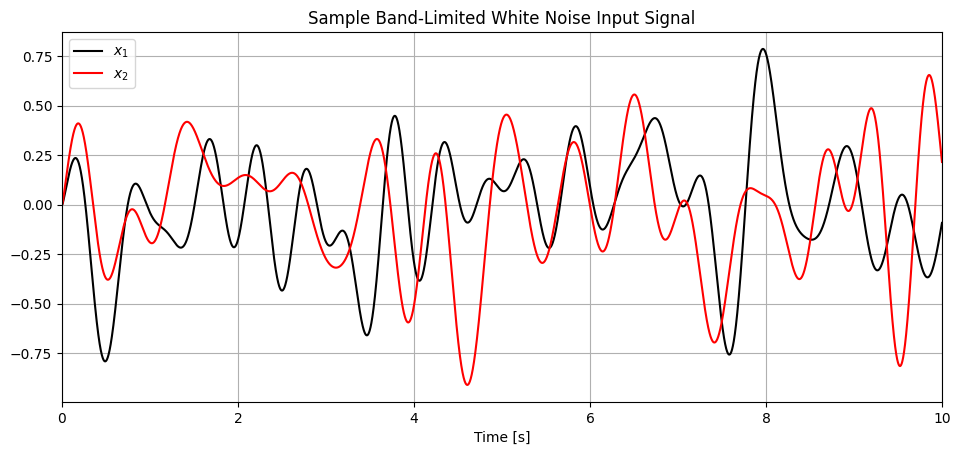

In [4]:
f = 2
rms = 0.30
delay= 0.5
sim_t=50

with nengo.Network() as model:
    stim1 = nengo.Node(output=nengo.processes.WhiteSignal(high=f, period=sim_t, rms=rms, y0=0, seed=0)) 
    stim2 = nengo.Node(output=nengo.processes.WhiteSignal(high=f, period=sim_t, rms=rms, y0=0, seed=1))
    stim = nengo.Node(size_in=2)

    nengo.Connection(stim1, stim[0])
    nengo.Connection(stim2, stim[1])

    p_stim = nengo.Probe(stim)

with nengo.Simulator(model, seed=0) as sim:
    sim.run(10)

f, pl = plt.subplots(1,1)
f.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_stim][:,0], 'k', label="$x_{1}$")
pl.plot(sim.trange(), sim.data[p_stim][:,1], 'r', label="$x_{2}$")
pl.set_title("Sample Band-Limited White Noise Input Signal")
pl.set_xlabel("Time [s]")
pl.set_xlim(0,10)
pl.legend()
pl.grid()

We'll be using a Node to regulate the Error value and disable training when needed

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


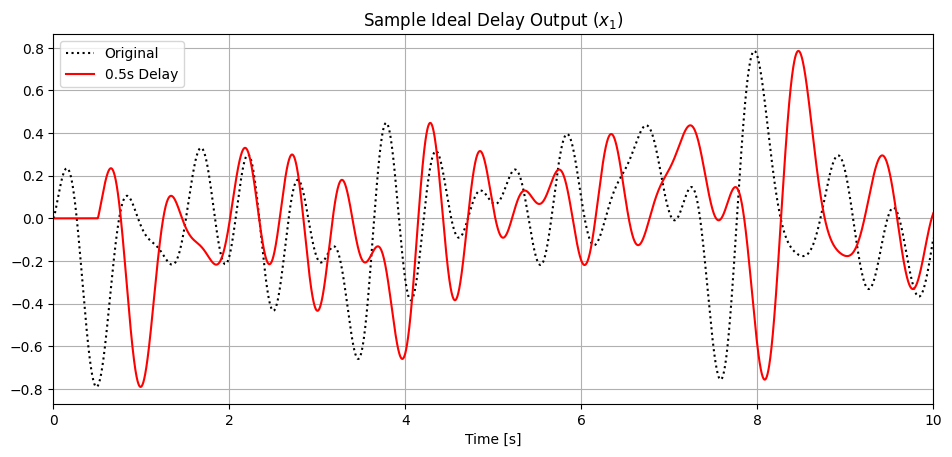

In [5]:
with model:
    err_node = nengo.Node(lambda t, x: x if t < sim_t * 0.8 else 0, size_in=2)

    # The synapse calculates the ideal delay transformation -- what we're trying to learn
    nengo.Connection(stim, err_node, synapse=IdealDelay(delay), transform=-1)

    p_err = nengo.Probe(err_node)

with nengo.Simulator(model, seed=0) as sim:
    sim.run(10)

f, pl = plt.subplots(1,1)
f.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_stim][:,0], 'k:', label="Original")
pl.plot(sim.trange(), -sim.data[p_err][:,0], 'r', label="0.5s Delay")
pl.set_title("Sample Ideal Delay Output ($x_{1}$)")
pl.set_xlabel("Time [s]")
pl.set_xlim(0,10)
pl.legend()
pl.grid()

Now we'll go ahead and introduce our LMUs

In [6]:
with model:
    # The LMUs!
    lmu_set = LMUStack(2, order=8)
    
    # Note: we learn between Ensembles, and since we use Nodes as Passthroughs for the LMUStack, we need an intermediate Ensemble that holds the LMU's output
    intermediate = nengo.Ensemble(2*8*100, 2*8)

    # Our Estimated Time-Delayed Signal
    out = nengo.Ensemble(250, 2)

    # Connecting to input to the LMUs
    nengo.Connection(stim, lmu_set.input)

    # Connecting the LMUs to the intermediate ensemble
    nengo.Connection(lmu_set.output, intermediate)
    
    # Learning Connections (remember we hooked up the ground truth to err in the previous section)
    learn_conn = nengo.Connection(intermediate, out, function=lambda x: [0,0], learning_rule_type=nengo.PES(5e-4))
    nengo.Connection(out, err_node, synapse=0)
    nengo.Connection(err_node, learn_conn.learning_rule, synapse=None)

    # Some Probes for Visualization
    p_stim = nengo.Probe(stim)
    p_out = nengo.Probe(out, synapse=0.05)
    
with nengo.Simulator(model, seed=0) as sim:
    sim.run(sim_t)

Build finished in 0:00:02.                                                      
Simulation finished in 0:00:13.                                                 


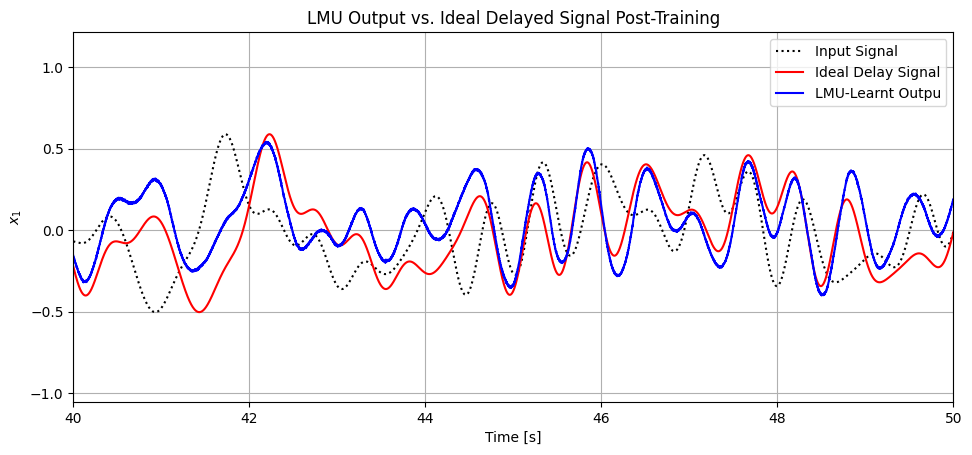

In [7]:
f, pl = plt.subplots(1,1)
f.subplots_adjust(right=1.5)

pl.plot(sim.trange(), sim.data[p_stim][:,0], 'k:', label="Input Signal")
pl.plot(sim.trange()+0.5, sim.data[p_stim][:,0], 'r', label="Ideal Delay Signal")
pl.plot(sim.trange(), sim.data[p_out][:,0], 'b', label="LMU-Learnt Outpu")
pl.set_title("LMU Output vs. Ideal Delayed Signal Post-Training")
pl.set_xlabel("Time [s]")
pl.set_ylabel("$x_{1}$")
pl.set_xlim(40,50)
pl.legend()
pl.grid()